<h1>Indexación Espacial con R-tree<br><small>Caso de estudio: OSMnx y Geopandas</small><br></h1>

<div style="text-align:center">
<b>Martín Josemaría Vuelta Rojas</b><br>
<code>martin.vuelta@softbutterfly.io</code><br/><br/>
<i>Universidad Nacional Mayor de San Marcos</i><br>
Facultad de Ciencias Físicas<br><br>
<i>SoftButterfly</i><br>
Cofundador y Director de Investigación y Desarrollo<br><br>
<i>Hack Space</i><br>
Lead Trainer y Lead Software Developer
</div>

## Ajustes gráficos

Aunque `osmnx` tiene sus propios estilos

In [1]:
%matplotlib inline

In [2]:
# Ajustes generales para los gráficos
from distutils.spawn import find_executable

from matplotlib.font_manager import *
from matplotlib.collections import *
from matplotlib.patches import *
from matplotlib.pylab import *
from matplotlib import colors

import seaborn
import gc

ioff()

rc('lines', linewidth=1)
rc('font', family='serif')

if find_executable('latex'):
    rc('text', usetex=True)

font_title = FontProperties(size=(1.728 * 12))
font_label = FontProperties(size=(1.2 * 12))
font_legend = FontProperties(size=(1.0 * 12))
font_ticks = FontProperties(size=(0.833 * 12))

seaborn.set(context='notebook', style='darkgrid')

## Elije un distrito

In [3]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

ox.config(
    log_console=True,
    use_cache=True
)

In [4]:
import osmnx as ox

district_name = input("Ingrese el nombre del distrito: ")
result = 1

while True:
    LIMA31 = ox.gdf_from_place(
        '{0}, Lima, Perú'.format(district_name),
        which_result=result
    )

    if isinstance(LIMA31['geometry'].tolist()[0], Point) :
        result = result + 1
        
        if result > 4:
            raise(ValueError("No se encontraron datos"))
            
        continue
    else:
        break

Ingrese el nombre del distrito:  Comas


### Mapa de calles

In [5]:
# "Bounding Box" mucho más grande que San Martin de Porres
offset = 0.1
west, south, east, north = LIMA31.unary_union.buffer(offset).bounds

In [6]:
# Red de vias contenidas en el "bounding box" de San Martin de Porres
LIMA31d = ox.graph_from_bbox(north, south, east, west, network_type='drive')

### Ahora el análisis de datos

In [7]:
# Como las cosas anteriores demoran mucho pues sacamos los datos de solo las intersecciones de 
# los puntos en el grafo de calles
xy = [(data['x'], data['y']) for node, data in LIMA31d.nodes(data=True)]
x, y = list(zip(*xy))

In [8]:
# GeoDataFrame de los nodos del mapa de calles que sacamos para LIMA31d :)
LIMA31dn = gpd.GeoDataFrame(data={'x':x, 'y':y})
LIMA31dn.crs = LIMA31.crs
LIMA31dn.name = 'nodes'
LIMA31dn['geometry'] = LIMA31dn.apply(lambda row: Point((row['x'], row['y'])), axis=1)

In [9]:
# Paso de poligono a multipligno en la geometria del distrito :)
LIMA31g = LIMA31['geometry'].iloc[0]
if isinstance(LIMA31g, Polygon):
    LIMA31g = MultiPolygon([LIMA31g])

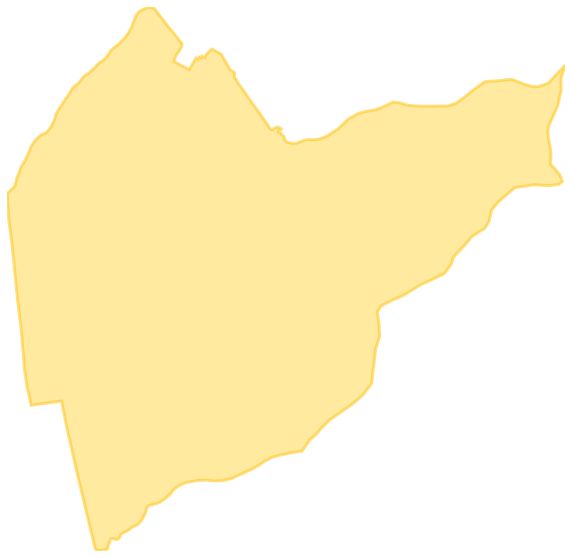

In [10]:
# plot the city
west, south, east, north = LIMA31.unary_union.bounds
fig, axs = plt.subplots(figsize=(10,10))
for polygon in LIMA31g:
    patch = PolygonPatch(
        polygon,
        fc='#ffd740',
        ec='#ffc107',
        linewidth=3,
        alpha=0.5,
        zorder=2
    )
    axs.add_patch(patch)
    
axs.set_xlim(west, east)
axs.set_ylim(south, north)
axs.axis('off')
plt.show()

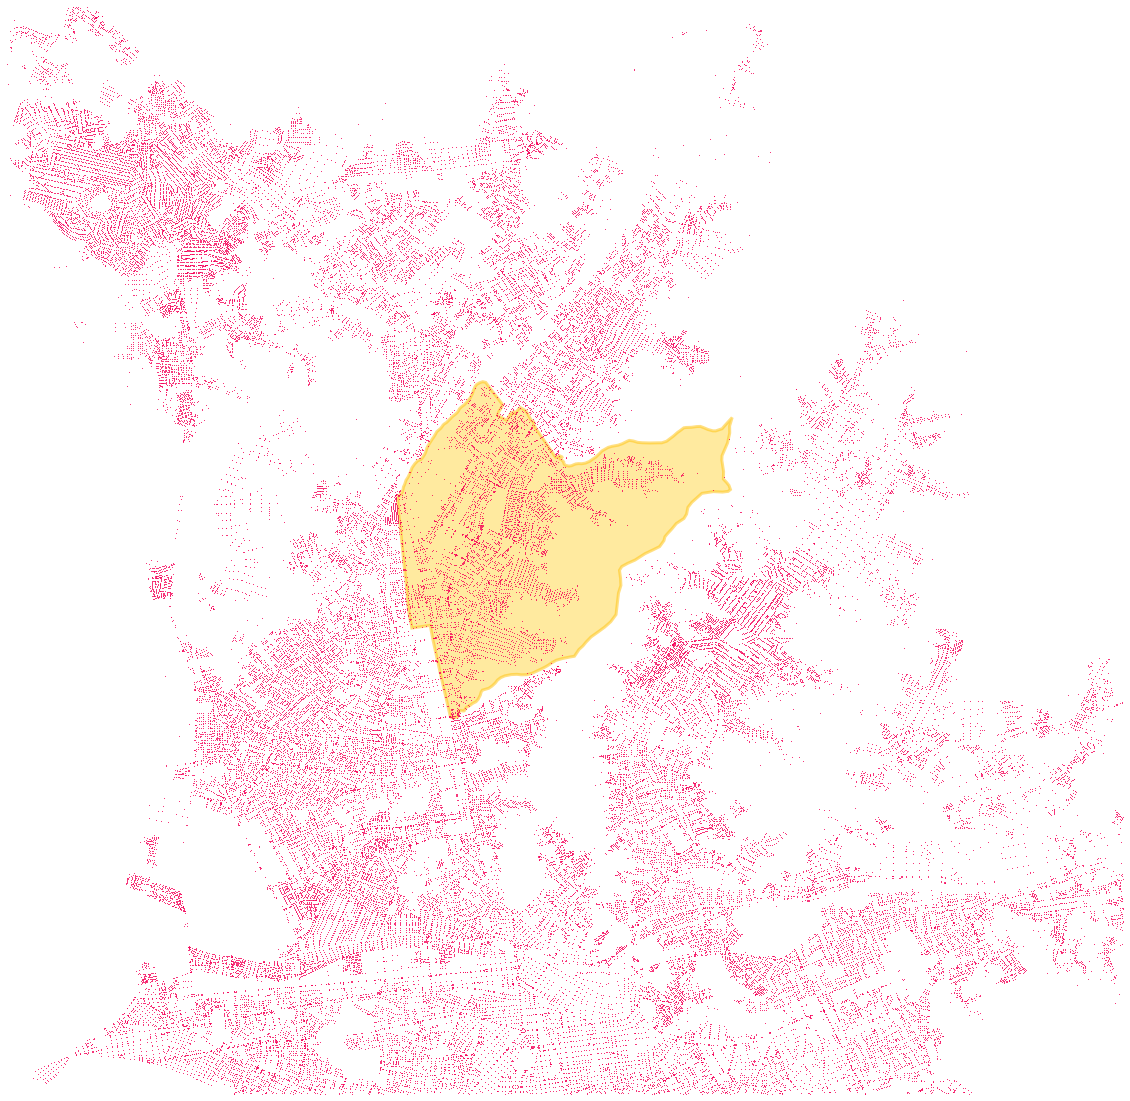

In [11]:
# Gráfico de las interseciones de calles (los nodos de grafo :D )
west, south, east, north = LIMA31dn.unary_union.bounds
fig, axs = plt.subplots(figsize=(20,20))
for polygon in LIMA31g:
    patch = PolygonPatch(
        polygon,
        fc='#ffd740',
        ec='#ffc107',
        linewidth=3,
        alpha=0.5,
        zorder=-1
    )
    axs.add_patch(patch)

axs.scatter(
    x=LIMA31dn['x'],
    y=LIMA31dn['y'],
    s=1,
    c='#f50057',
    linewidth=0,
    zorder=1
)
    
axs.set_xlim(west, east)
axs.set_ylim(south, north)
axs.axis('off')
plt.show()

In [12]:
# Esto es lo que construye el r-tree, hay que revisar la implel,entacion de de geo pandas :'(
# si: Spatial Index
LIMA31dnsi = LIMA31dn.sindex

# pmi: Posibles indices coincidentes (matching)
LIMA31dnpmi = list(LIMA31dnsi.intersection(LIMA31g.bounds))

# pom: Posibles coincidencias (matching)
LIMA31dnpom = LIMA31dn.iloc[LIMA31dnpmi]

# prm: Coincidencias precisas?
LIMA31dnprm = LIMA31dnpom[LIMA31dnpom.intersects(LIMA31g)]

In [13]:
# Nodos dentro del distrito
LIMA31dnwg = LIMA31dnprm
LIMA31dnog = LIMA31dn[~LIMA31dn.isin(LIMA31dnwg)]

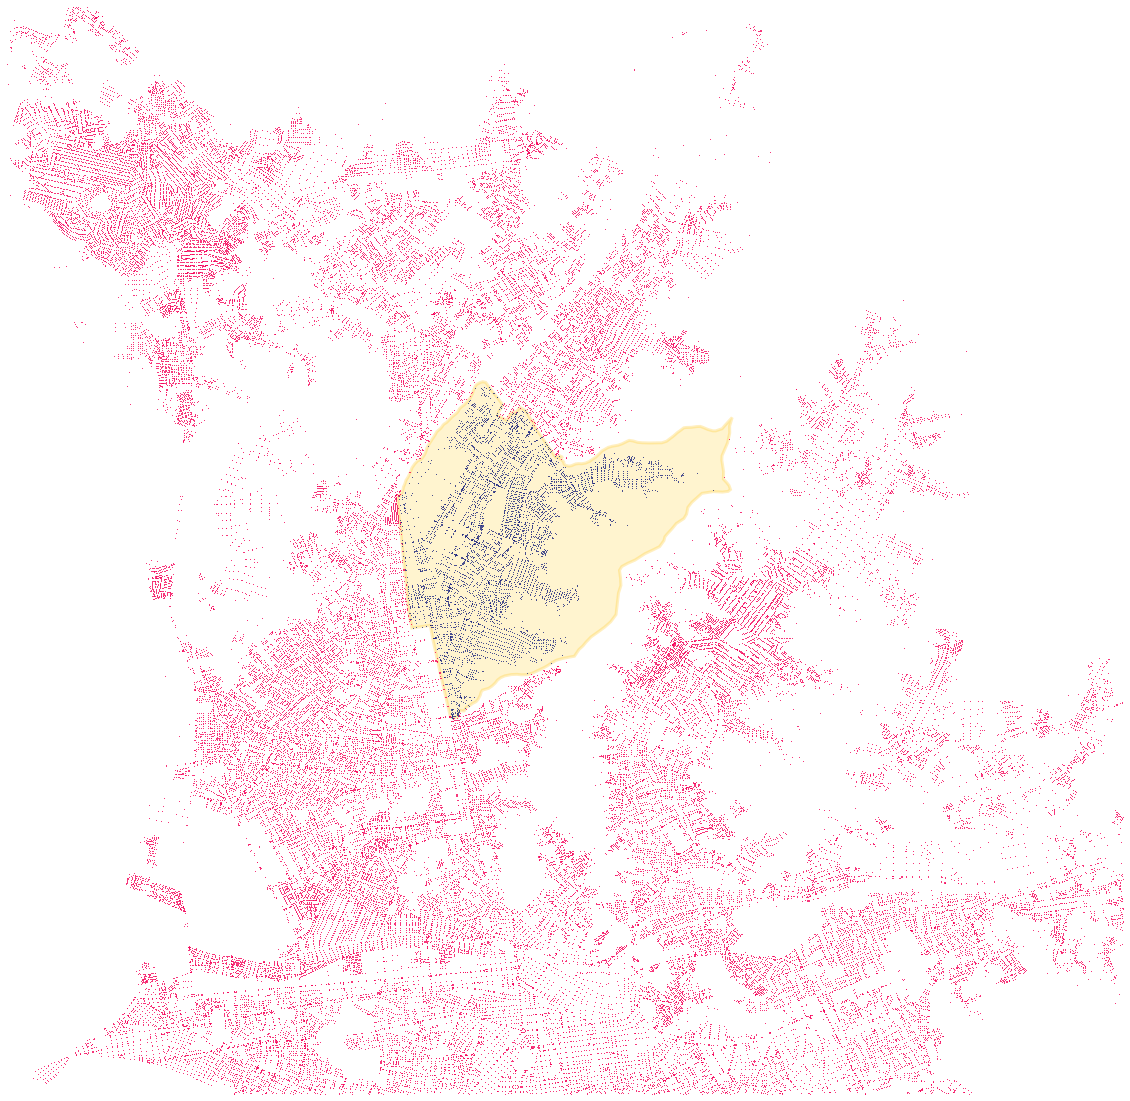

In [14]:
# Gráfico de las ijnterseciones de calles (los nodos de grafo :D )
west, south, east, north = LIMA31dn.unary_union.bounds
fig, axs = plt.subplots(figsize=(20,20))
for polygon in LIMA31g:
    patch = PolygonPatch(
        polygon,
        fc='#ffd740',
        ec='#ffc107',
        linewidth=3,
        alpha=0.25,
        zorder=-1
    )
    axs.add_patch(patch)

# Dentro del distrito
axs.scatter(
    x=LIMA31dnwg['x'],
    y=LIMA31dnwg['y'],
    s=1,
    c='#1a237e',
    linewidth=0,
    zorder=1
)

# Fuera del del distrito
axs.scatter(
    x=LIMA31dnog['x'],
    y=LIMA31dnog['y'],
    s=1,
    c='#f50057',
    linewidth=0,
    zorder=1
)
    
axs.set_xlim(west, east)
axs.set_ylim(south, north)
axs.axis('off')
plt.show()